In [219]:
"""
!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt"""

'\n!git clone -b EMT https://github.com/pop756/Quantum_KAN.git\n%cd Quantum_KAN\n!pip install -r requirements.txt'

In [500]:
#setting 
optimization_level = 2
resilience_level = 1
l = 0

In [501]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

def create_trotterized_ising_model_circuit(num_qubits, trotter_steps, time):
    """
    Trotterization을 사용하여 Ising 모델의 양자 서킷을 생성합니다.
    각 Rz 게이트의 파라미터는 Qiskit Parameter로 동적으로 설정됩니다.

    Parameters:
    - num_qubits: 큐비트의 수
    - trotter_steps: Trotterization 단계 수
    - time: 진화 시간

    Returns:
    - QuantumCircuit: 생성된 양자 서킷
    - dict: 서킷 파라미터 사전
    """
    qc = QuantumCircuit(num_qubits)
    delta_t = time / trotter_steps

    # 파라미터 설정
    h_params = [Parameter(f'h_{i}') for i in range(num_qubits)]
    J_params = [[Parameter(f'J_{i}_{j}') for j in range(num_qubits)] for i in range(num_qubits)]

    for _ in range(trotter_steps):
        # 자기 상호작용 항목 추가
        for i in range(num_qubits):
            qc.rx(2 * h_params[i] * delta_t, i)

        # 스핀 간 상호작용 항목 추가
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if J_params[i][j] != 0:
                    qc.cx(i, j)
                    qc.rz(2 * J_params[i][j] * delta_t, j)
                    qc.cx(i, j)

    return qc, h_params, J_params

def create_trotterized_ising_model_circuit_train(num_qubits, trotter_steps, time):
    """
    Trotterization을 사용하여 Ising 모델의 양자 서킷을 생성합니다.
    각 Rz 게이트의 파라미터는 Qiskit Parameter로 동적으로 설정됩니다.

    Parameters:
    - num_qubits: 큐비트의 수
    - trotter_steps: Trotterization 단계 수
    - time: 진화 시간

    Returns:
    - QuantumCircuit: 생성된 양자 서킷
    - dict: 서킷 파라미터 사전
    """
    qc = QuantumCircuit(num_qubits)
    delta_t = time / trotter_steps

    # 파라미터 설정
    h_params = [Parameter(f'h_{i}') for i in range(num_qubits)]
    J_params = [[Parameter(f'J_{i}_{j}') for j in range(num_qubits)] for i in range(num_qubits)]

    for _ in range(trotter_steps):
        # 자기 상호작용 항목 추가
        for i in range(num_qubits):
            qc.rx(2 * h_params[i] * delta_t, i)

        # 스핀 간 상호작용 항목 추가
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if J_params[i][j] != 0:
                    qc.rz(2 * J_params[i][j] * delta_t, j)
    return qc, h_params, J_params

# 파라미터 설정
num_qubits = 4
trotter_steps = 2  # Trotterization 단계 수
time = 1.0  # 진화 시간

# Trotterization을 사용한 Ising 모델 서킷 생성
trotterized_ising_circuit, h_params, J_params = create_trotterized_ising_model_circuit(num_qubits, trotter_steps, time)
trotterized_ising_circuit_train, h_params, J_params = create_trotterized_ising_model_circuit_train(num_qubits, trotter_steps, time)




In [503]:
# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_ibm_provider
from qiskit_aer import AerSimulator
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')

backend_name = 'ibm_nazca'
backend_error = service.backend(backend_name)

In [504]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian


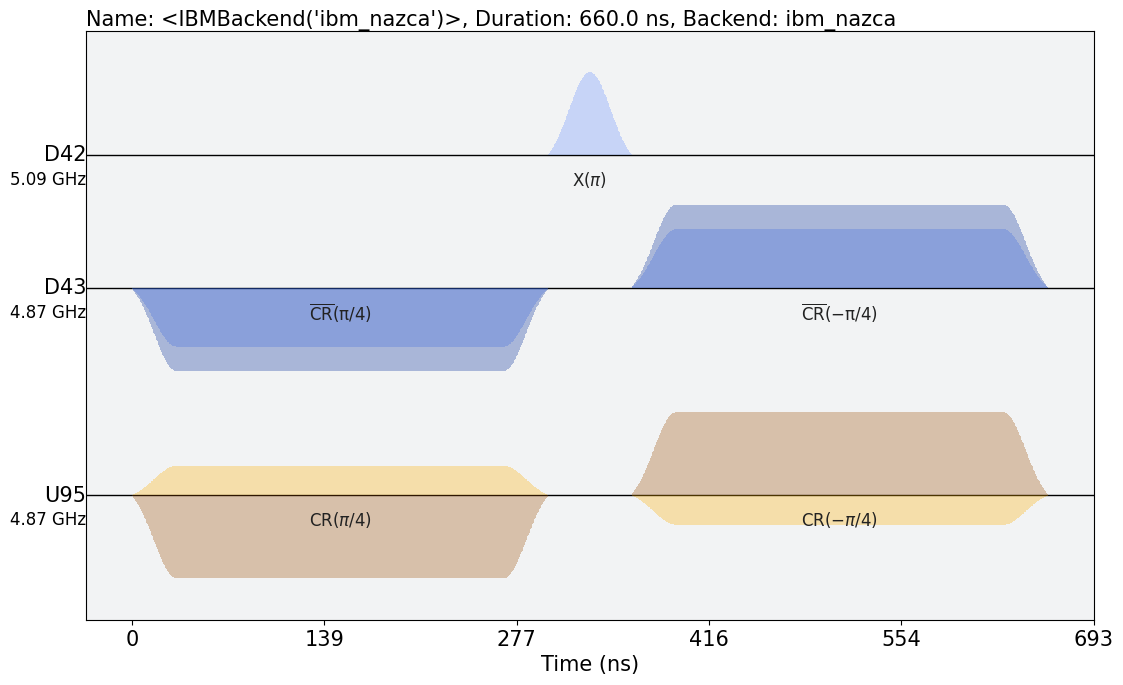

In [505]:
from qiskit import QuantumCircuit
from qiskit import pulse
from qiskit import schedule
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Options
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=[42, 43])


#qubit_use = [37,38,39,40,41,42,43]
qubit_use = [0,1,2,3,4,5,6]
circ = QuantumCircuit(2, 2)
circ.ecr(0, 1)
from qiskit import transpile
circ = passmanager.run(circ,backend_error)
pulse_schedule = schedule(circ,backend=backend_error)
pulse_schedule.draw(backend=backend_error)

In [506]:
init_list = []
for item in backend_error.target['ecr']:
    if item[0] in qubit_use and item[1] in qubit_use:
        init_list.append(item)

In [497]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 ,SamplerV2
from qiskit_ibm_runtime import Session
import numpy as np


init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)

def update_ecr(l,init_list,backend):
  layouts = {}
  for initial_layout in init_list:
    custom_gate = Gate(f"error", 2, [])
    pulse_schedule = backend.target['ecr'][initial_layout].calibration
    with pulse.build(backend, name=f'err_{initial_layout}') as real_pulse:
      for j in range(2):
        index=0
        pulse_copy = copy.deepcopy(pulse_schedule)
        if j == 0:
              duration = round(pulse_copy.instructions[0][1].pulse.duration/32)*16
              width = round(pulse_copy.instructions[0][1].pulse._params['width']/32)*16
              x_duration = pulse_copy.instructions[2][1].pulse.duration
              sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32)*16
        for pul in pulse_copy.instructions:
            try:
              pul[1].pulse._params['width']
              if index == 0 or index ==3:
                index+=1
                continue
              else:
                pul[1].lpulse.duration = duration
                pul[1].pulse._params['sigma'] = sigma
                pul[1].pulse._params['width'] = width
                pulse.play(pul[1].pulse,pul[1].channel)
                if index<2:
                  pulse.delay(x_duration,pul[1].channel)
                  pass
                index+=1
            except:
              if j == 0:
                pulse.delay(duration,pul[1].channel)
                pulse.play(pul[1].pulse,pul[1].channel)
                index+=1
              else:
                pulse.delay(duration*2,pul[1].channel)
                pul[1].pulse._params['angle']+=3.14
                pulse.play(pul[1].pulse,pul[1].channel)
                index+=1
              pass

  
    with pulse.build(backend, name=f'err_{initial_layout}') as my_schedule:
        for j in range(2):
          index=0
          pulse_copy = copy.deepcopy(pulse_schedule)
          if j == 0:
              duration = round(pulse_copy.instructions[0][1].pulse.duration/32)*16
              width = round(pulse_copy.instructions[0][1].pulse._params['width']/32)*16
              x_duration = pulse_copy.instructions[2][1].pulse.duration
              sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32)*16
        for pul in pulse_copy.instructions:
            try:
              pul[1].pulse._params['width']
              if index == 0 or index ==3:
                index+=1
                continue
              else:
                pul[1].pulse.duration = duration
                pul[1].pulse._params['sigma'] = sigma
                pul[1].pulse._params['width'] = width
                pulse.play(pul[1].pulse,pul[1].channel)
                if index<2:
                  pulse.delay(x_duration,pul[1].channel)
                  pass
                index+=1
            except:
              if j == 0:
                pulse.delay(duration,pul[1].channel)
                pulse.play(pul[1].pulse,pul[1].channel)
                index+=1
              else:
                pulse.delay(duration*2,pul[1].channel)
                pul[1].pulse._params['angle']+=3.14
                pulse.play(pul[1].pulse,pul[1].channel)
                index+=1
              pass

    layouts[initial_layout] = InstructionProperties(calibration=my_schedule)
    if l == 0:
      backend.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(real_pulse)))
    else:
      backend.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(real_pulse+my_schedule)))
  backend.target.add_instruction(
      custom_gate,
      layouts,
  )


  return my_schedule,real_pulse


my_schedule,pulse_real = update_ecr(0,init_list,backend_error)
initial_layout = init_list[0]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


In [509]:
qc1.draw(idle_wires=False)

┌───┐┌──────┐┌──────┐┌─┐   
q_0 -> 3 ┤ X ├┤0     ├┤0     ├┤M├───
         ├───┤│  Ecr ││  Ecr │└╥┘┌─┐
q_1 -> 4 ┤ X ├┤1     ├┤1     ├─╫─┤M├
         └───┘└──────┘└──────┘ ║ └╥┘
    c: 2/══════════════════════╩══╩═
                               0  1

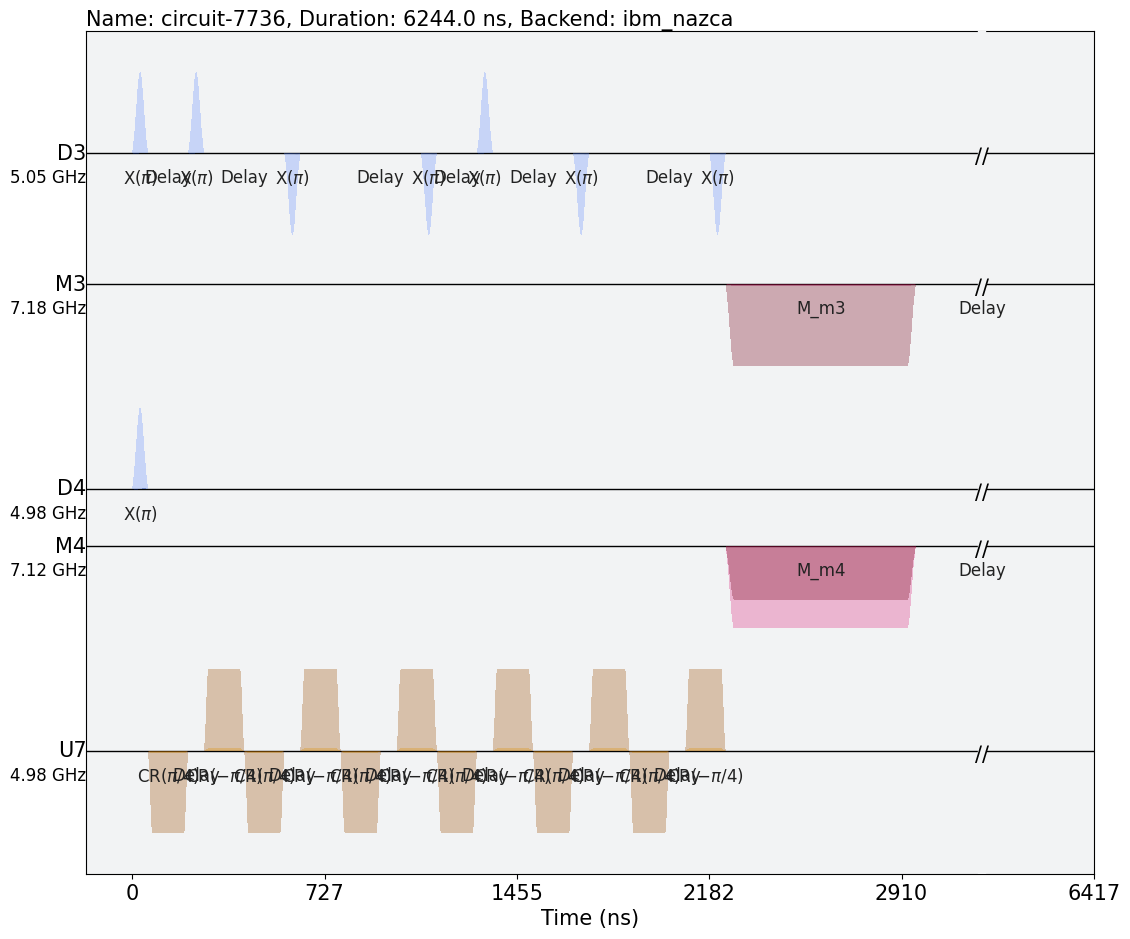

In [508]:
schedule(qc1,backend=backend_error).draw(backend=backend_error)

In [ ]:
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=[37,38])
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.ecr(0)

In [450]:

passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_error, initial_layout=[37,38,39,40])

from qiskit.quantum_info import SparsePauliOp
"""
qc_list = []
for i in range(20):
    qc1 = QuantumCircuit(2, 2)
    if init[0] == '1':
        qc1.x(0)
    if init[1] == '1':
        qc1.x(1)
    #qc1.ecr(0,1)
    #qc1.ecr(0,1)
    for j in range(i):
        qc1.ecr(0,1)
        qc1.ecr(0,1)
    qc1.measure(0,0)
    qc1.measure(1,1)
    qc1 = passmanager.run(qc1)
    qc_list.append(qc1)"""
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,10])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)
with Session(backend=backend_error,) as session:
    estimator = EstimatorV2(session=session)
    estimator.resilience_level = resilience_level
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
    #job = sampler.run(qc_list,shots=8000)
    job.update_tags(['ecr_train',f"l={1+l}"])

In [296]:
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')


backend = service.backend(backend_name)

In [297]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2,SamplerV2
from qiskit_ibm_runtime import Session
init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)

def update_ecr_real(l,init_list,backend):
  layouts = {}
  if l == 0:
    pass
  else:
    for initial_layout in init_list:
      custom_gate = Gate(f"error", 2, [])
      pulse_schedule = backend.target['ecr'][initial_layout].calibration
      pulse_copy = copy.deepcopy(pulse_schedule)
      with pulse.build(backend, name=f'err_{initial_layout}') as real_pulse:
          index=0
          for pul in pulse_schedule.instructions:
              if index == 0:
                duration = pul[1].pulse.duration
                x_duration = pulse_copy.instructions[2][1].pulse.duration
                pulse.delay(duration,pulse_schedule.instructions[2][1].channel)


              pulse.play(pul[1].pulse,pul[1].channel)
              if index<2:
                pulse.delay(x_duration,pul[1].channel)
              index+=1

      with pulse.build(backend, name=f'err_{initial_layout}') as my_schedule:
        for j in range(2):
          index=0
          pulse_copy = copy.deepcopy(pulse_schedule)
          if j == 0:
                duration = round(pulse_copy.instructions[0][1].pulse.duration/32*l)*16
                width = round(pulse_copy.instructions[0][1].pulse._params['width']/32*l)*16
                x_duration = pulse_copy.instructions[2][1].pulse.duration
                sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32*l)*16
          for pul in pulse_copy.instructions:
              try:
                pul[1].pulse._params['width']
                pul[1].pulse.duration = duration
                pul[1].pulse._params['sigma'] = sigma
                pul[1].pulse._params['width'] = width
                pulse.play(pul[1].pulse,pul[1].channel)
                if index<2:
                  pulse.delay(x_duration,pul[1].channel)
                  pass
                index+=1
              except:
                if j == 0:
                  pulse.delay(duration,pul[1].channel)
                  pulse.play(pul[1].pulse,pul[1].channel)
                else:
                  pulse.delay(duration*2,pul[1].channel)
                  pul[1].pulse._params['angle']+=3.14
                  pulse.play(pul[1].pulse,pul[1].channel)
                pass

      layouts[initial_layout] = InstructionProperties(calibration=my_schedule)

      backend.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(real_pulse+my_schedule)))





update_ecr_real(l,init_list,backend)
initial_layout = init_list[1]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


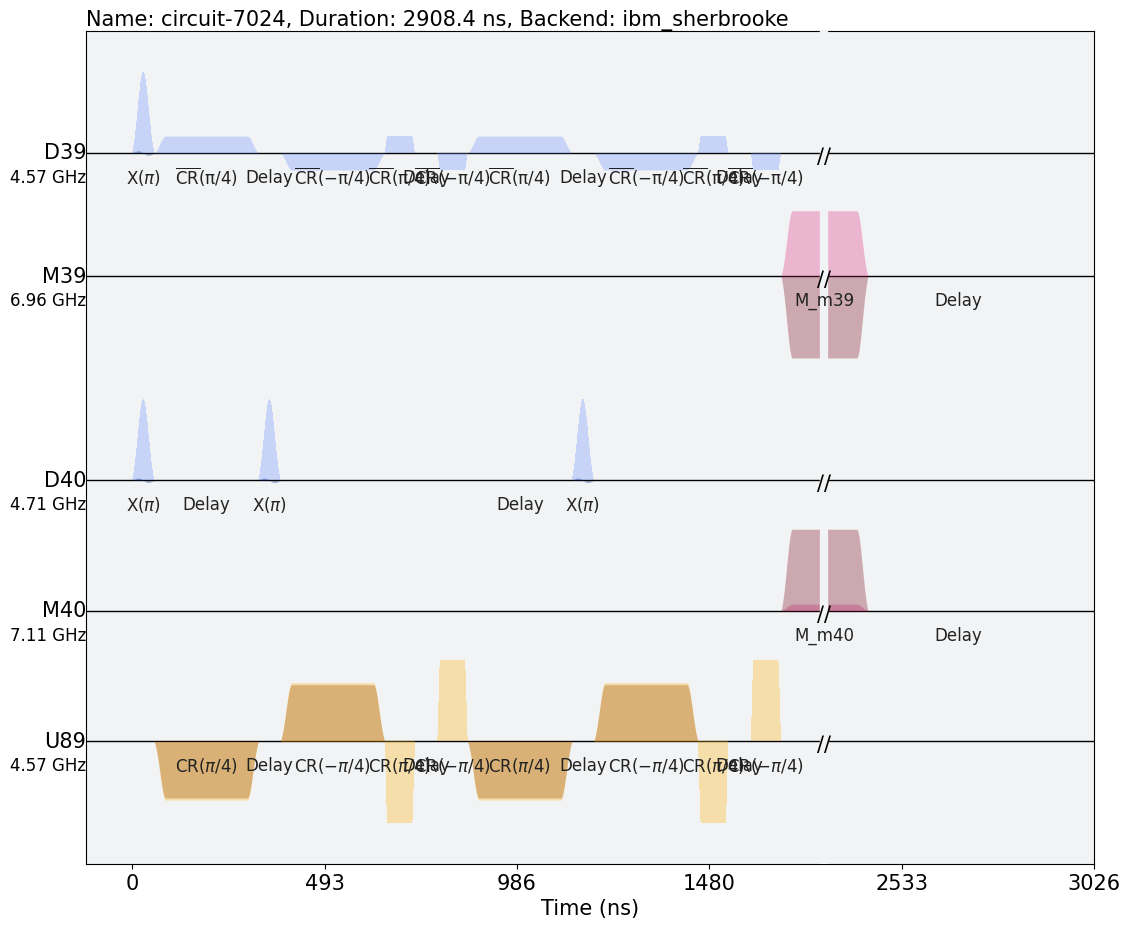

In [298]:
schedule(qc1,backend=backend).draw(backend=backend)

In [443]:
passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, initial_layout=qubit_use[:4])

from qiskit.quantum_info import SparsePauliOp
"""
qc_list = []
for i in range(20):
    qc1 = QuantumCircuit(2, 2)
    if init[0] == '1':
        qc1.x(0)
    if init[1] == '1':
        qc1.x(1)
    #qc1.ecr(0,1)
    #qc1.ecr(0,1)
    for j in range(i):
        qc1.ecr(0,1)
        qc1.ecr(0,1)
    qc1.measure(0,0)
    qc1.measure(1,1)
    qc1 = passmanager.run(qc1)
    qc_list.append(qc1)"""
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,10])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)



with Session(backend=backend) as session:
    estimator = EstimatorV2(session=session)
    estimator.resilience_level = resilience_level
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
    #job = sampler.run(qc_list,shots=8000)
    job.update_tags(['ecr',f"l={1+l}"])

In [454]:
from qiskit.primitives import StatevectorEstimator
import torch
from qiskit.quantum_info import SparsePauliOp
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,10])
estimator = StatevectorEstimator()
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
job_train = estimator.run([(trotterized_ising_circuit_train, hamiltonian, theta[i]) for i in range(100)])
job_valid = estimator.run([(trotterized_ising_circuit, hamiltonian, theta[i]) for i in range(100)])

In [455]:
train_label = torch.tensor(np.array([result.data.evs for result in job_train.result()]),dtype=torch.float32)
validation_label = torch.tensor(np.array([result.data.evs for result in job_valid.result()]),dtype=torch.float32)

In [459]:
torch.stack([train_label,train_set[0]],dim=1)

tensor([[ 2.3758e+00, -1.6270e-01],
        [-3.5674e-01,  6.2831e-02],
        [ 2.9056e+00, -2.0350e-01],
        [-6.3844e-03, -1.2018e-01],
        [ 1.2500e+00, -2.1277e-03],
        [ 4.0415e-01,  2.9842e-02],
        [ 9.3455e-01, -1.7607e-01],
        [ 3.0268e-01, -5.9810e-02],
        [-4.8725e-01,  1.3561e-01],
        [ 9.2050e-01, -1.6434e-03],
        [ 2.1321e+00, -1.8122e-01],
        [ 2.8156e+00, -2.2857e-02],
        [ 1.6701e+00,  7.6017e-02],
        [ 1.3038e+00, -3.2221e-02],
        [ 1.5118e+00, -2.8426e-03],
        [ 2.8088e+00,  4.5306e-02],
        [ 1.2832e-01, -5.3720e-02],
        [ 1.4896e+00, -9.0094e-02],
        [ 2.8523e-01,  4.6058e-02],
        [ 2.1079e+00,  9.8525e-02],
        [ 2.2914e+00, -1.8230e-01],
        [ 2.4705e+00, -1.3722e-03],
        [ 9.4583e-01,  6.8254e-03],
        [ 3.2497e+00,  6.5256e-02],
        [ 3.1005e+00, -8.3991e-02],
        [ 2.0278e-01, -1.6695e-01],
        [ 3.9661e-01, -6.5121e-02],
        [ 3.1635e+00, -1.446

In [458]:
torch.nn.MSELoss()(train_label,train_set[0])

tensor(4.4591)

In [325]:
torch.stack([validation_label, valid_set[0],valid_set[1],valid_set[2]],dim=1)

tensor([[ 1.5949e+00,  4.3283e-01,  2.5870e-01,  2.6588e-01],
        [ 6.6771e-01, -2.6375e-01, -1.2667e-01,  8.8674e-02],
        [ 2.8194e+00,  9.0207e-01,  1.1795e-01, -2.0333e-01],
        [ 1.2064e+00,  9.1661e-02, -3.2446e-01,  3.7611e-03],
        [ 2.2704e+00,  8.4217e-01, -3.9812e-01, -2.0739e-01],
        [ 2.3728e+00,  9.4277e-01, -5.3007e-01, -3.2548e-01],
        [ 1.8065e+00,  9.0574e-01, -9.6281e-03, -1.6936e-02],
        [ 2.0651e+00,  7.8551e-01, -1.2123e-01, -1.5739e-02],
        [ 1.3334e+00,  8.4168e-01, -6.6635e-01,  4.4890e-01],
        [ 9.7672e-01,  3.0297e-01,  2.4070e-01, -2.4314e-01],
        [ 2.3975e+00,  9.4004e-01, -1.8054e-01, -1.9355e-01],
        [ 3.0344e+00,  1.2010e+00, -3.3429e-01, -4.1557e-01],
        [ 2.1315e+00,  6.1268e-01, -4.1349e-01, -2.7990e-01],
        [ 1.6236e+00,  7.3652e-01, -1.1575e-01, -4.3439e-01],
        [ 2.1018e+00,  1.0254e+00, -4.9162e-01, -5.2735e-01],
        [ 2.1714e+00,  1.1246e+00, -7.3940e-02, -8.8934e-02],
        

In [316]:
torch.nn.MSELoss()(validation_label, valid_set[1])

tensor(5.9628)

In [76]:
torch.sum(abs(validation_label)),torch.sum(abs(train_set[0]))

(tensor(179.8222), tensor(43.0763))

In [457]:
import torch
l_list = [1]
train_set = []
valid_set = []

for l in l_list:
  train_list = []
  valid_list = []

  job_train = service.jobs(backend_name=backend_name,job_tags=['ecr_train',f'l={l}'],pending=False)
  job_valid = service.jobs(backend_name=backend_name,job_tags=['ecr',f'l={l}'],pending=False)
  for res in job_train[0].result():
    train_list.append(res.data.evs)
  """
  for res in job_valid[0].result():
    valid_list.append(res.data.evs)
  """
  train_set.append(torch.tensor(np.array(train_list),dtype=torch.float32))
  #valid_set.append(torch.tensor(np.array(valid_list),dtype=torch.float32))


In [348]:
inputs = job_train[0].inputs

In [326]:
train_data = torch.stack(train_set,dim=1)
train_data = train_data.to(torch.float32)
validation_data = torch.stack(valid_set,dim=1)
validation_data = validation_data.to(torch.float32)

C:\Users\pop75\AppData\Local\Temp\ipykernel_13828\1044891312.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(validation_data), torch.tensor(validation_label))
C:\Users\pop75\AppData\Local\Temp\ipykernel_13828\1044891312.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_dataset = TensorDataset(torch.tensor(validation_data), torch.tensor(validation_label))
c:\Users\pop75\anaconda3\envs\EMT\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they h

Epoch 1/200, Training Loss: 5.365536570549011, Validation Loss: 4.649104499816895
Epoch 2/200, Training Loss: 4.098173046112061, Validation Loss: 3.3184445977210997
Epoch 3/200, Training Loss: 2.7458461046218874, Validation Loss: 2.047366017103195
Epoch 4/200, Training Loss: 1.576906108856201, Validation Loss: 1.1250521421432496
Epoch 5/200, Training Loss: 1.0280198872089386, Validation Loss: 0.9019564926624298
Epoch 6/200, Training Loss: 0.948705431818962, Validation Loss: 0.9354542791843414
Epoch 7/200, Training Loss: 0.9716450244188308, Validation Loss: 0.8834169387817383
Epoch 8/200, Training Loss: 0.8852136194705963, Validation Loss: 0.8807812184095383
Epoch 9/200, Training Loss: 0.9077697366476059, Validation Loss: 0.8736632376909256
Epoch 10/200, Training Loss: 0.8896483540534973, Validation Loss: 0.8698807001113892
Epoch 11/200, Training Loss: 0.905151292681694, Validation Loss: 0.8665195047855377
Epoch 12/200, Training Loss: 0.8916399300098419, Validation Loss: 0.8644485741853

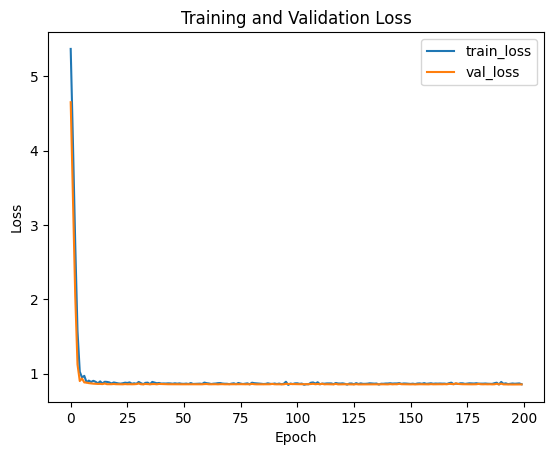

<built-in method stack of type object at 0x00007FFE2C3149D0>


C:\Users\pop75\AppData\Local\Temp\ipykernel_13828\1044891312.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [330]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([5,3,1],grid=1)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output


# 데이터셋 및 데이터로더
train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_label))
validation_dataset = TensorDataset(torch.tensor(validation_data), torch.tensor(validation_label))
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(3, 64)
        self.layer2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x
    
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 은닉 상태 초기화
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 셀 상태 초기화
        out, _ = self.lstm(x, (h0, c0))  # LSTM을 통해 시퀀스 처리
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 fully connected layer에 적용하여 출력 생성
        return out

# 모델 초기화
model = MLP()
# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 200
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))


    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    validation_losses.append(validation_loss / len(validation_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {validation_losses[-1]}')

# 손실(loss) 그래프
plt.plot(train_losses, label='train_loss')
plt.plot(validation_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 검증 데이터로 예측
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = model(validation_inputs)
    print(torch.stack)


In [331]:
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([predictions,validation_data[:,0],validation_label],dim=1))

tensor([[ 2.1751e+00,  4.3283e-01,  1.5949e+00],
        [ 2.0811e+00, -2.6375e-01,  6.6771e-01],
        [ 2.2142e+00,  9.0207e-01,  2.8194e+00],
        [ 2.1242e+00,  9.1661e-02,  1.2064e+00],
        [ 2.1614e+00,  8.4217e-01,  2.2704e+00],
        [ 2.1814e+00,  9.4277e-01,  2.3728e+00],
        [ 2.2066e+00,  9.0574e-01,  1.8065e+00],
        [ 2.1887e+00,  7.8551e-01,  2.0651e+00],
        [ 2.1841e+00,  8.4168e-01,  1.3334e+00],
        [ 2.1336e+00,  3.0297e-01,  9.7672e-01],
        [ 2.1981e+00,  9.4004e-01,  2.3975e+00],
        [ 2.2389e+00,  1.2010e+00,  3.0344e+00],
        [ 2.1458e+00,  6.1268e-01,  2.1315e+00],
        [ 2.1806e+00,  7.3652e-01,  1.6236e+00],
        [ 2.2045e+00,  1.0254e+00,  2.1018e+00],
        [ 2.2245e+00,  1.1246e+00,  2.1714e+00],
        [ 2.1825e+00,  5.2681e-01,  1.0192e+00],
        [ 2.1481e+00,  6.5966e-01,  2.7841e+00],
        [ 2.1095e+00, -3.6165e-03,  5.9596e-01],
        [ 2.2041e+00,  1.0087e+00,  3.3604e+00],
        [ 2.2585e+00

C:\Users\pop75\AppData\Local\Temp\ipykernel_13828\1514016890.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [329]:
with torch.no_grad():
    validation_inputs = torch.tensor(train_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([predictions,train_data[:,0],train_label],dim=1))

tensor([[ 1.7306, -0.5239,  2.3758],
        [ 1.6139,  1.2139, -0.3567],
        [ 1.8006,  1.8152,  2.9056],
        [ 1.6245, -1.2114, -0.0064],
        [ 1.7183,  0.9477,  1.2500],
        [ 1.7349, -0.8114,  0.4042],
        [ 1.6842,  0.3179,  0.9345],
        [ 1.6431,  1.1891,  0.3027],
        [ 1.7047,  0.5486, -0.4873],
        [ 1.5670, -1.2094,  0.9205],
        [ 1.7770,  0.7473,  2.1321],
        [ 1.6948, -0.5114,  2.8156],
        [ 1.7321,  1.4837,  1.6701],
        [ 1.6818,  0.8678,  1.3038],
        [ 1.7162,  0.7854,  1.5118],
        [ 1.7988, -0.1913,  2.8088],
        [ 1.7335,  0.3757,  0.1283],
        [ 1.7516,  0.5934,  1.4896],
        [ 1.6134, -1.0035,  0.2852],
        [ 1.7711,  0.1060,  2.1079],
        [ 1.7291,  0.1486,  2.2914],
        [ 1.7228, -0.5266,  2.4705],
        [ 1.7645, -0.6591,  0.9458],
        [ 1.8139,  0.2130,  3.2497],
        [ 1.7727,  0.0457,  3.1005],
        [ 1.7237, -0.0855,  0.2028],
        [ 1.6984, -1.0396,  0.3966],
 

C:\Users\pop75\AppData\Local\Temp\ipykernel_13828\905068060.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(train_data)


In [273]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token='06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854'
)
job = service.job('csjt5xf1k2e0008nt9kg')
job_result = job.result()
ZNE_result = []
for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs,validation_label[idx]}")
    ZNE_result.append(pub_result.data.evs)
ZNE_result = torch.tensor(np.array(ZNE_result),dtype=torch.float32)

Expectation values for pub 0: (array(0.70505618), tensor(1.5949))
Expectation values for pub 1: (array(0.68739954), tensor(0.6677))
Expectation values for pub 2: (array(1.25423963), tensor(2.8194))
Expectation values for pub 3: (array(0.71228757), tensor(1.2064))
Expectation values for pub 4: (array(0.47089056), tensor(2.2704))
Expectation values for pub 5: (array(0.50368146), tensor(2.3728))
Expectation values for pub 6: (array(0.82585623), tensor(1.8065))
Expectation values for pub 7: (array(1.0422453), tensor(2.0651))
Expectation values for pub 8: (array(0.38457497), tensor(1.3334))
Expectation values for pub 9: (array(0.58300434), tensor(0.9767))
Expectation values for pub 10: (array(1.05250466), tensor(2.3975))
Expectation values for pub 11: (array(1.00838631), tensor(3.0344))
Expectation values for pub 12: (array(1.0773986), tensor(2.1315))
Expectation values for pub 13: (array(0.65248489), tensor(1.6236))
Expectation values for pub 14: (array(0.90121891), tensor(2.1018))
Expecta

AttributeError: module 'torch' has no attribute 'tnesor'

In [274]:
ZNE_result = torch.tensor(np.array(ZNE_result),dtype=torch.float32)

In [276]:
criterion(ZNE_result,validation_label)

tensor(2.1584)